* Notebook modified by nov05 on 2025-06-11

In [1]:
%%capture
!pip install --upgrade datasets
## Successfully installed datasets-3.6.0 fsspec-2025.3.0
!pip install langchain_google_vertexai langchain_core langgraph
## Successfully installed httpx-sse-0.4.0 langchain_google_vertexai-2.0.24 langgraph-0.4.8 langgraph-checkpoint-2.0.26
## langgraph-prebuilt-0.2.2 langgraph-sdk-0.1.70 ormsgpack-1.10.0 pyarrow-19.0.1 validators-0.35.0
!pip install -U langchain-community
## Successfully installed dataclasses-json-0.6.7 langchain-community-0.3.25 langchain-core-0.3.65 langsmith-0.3.45
## marshmallow-3.26.1 mypy-extensions-1.1.0 pydantic-settings-2.9.1 python-dotenv-1.1.0 typing-inspect-0.9.0
!pip install -U duckduckgo-search
## Successfully installed duckduckgo-search-8.0.3 primp-0.15.0
!pip install arxiv
## Successfully installed arxiv-2.2.0 feedparser-6.0.11 sgmllib3k-1.0.0
!pip install wikipedia
## Successfully installed wikipedia-1.4.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.oauth2 import service_account
json_path = "/content/drive/MyDrive/config/20250604_google_service_account_key-lucid-bebop-461722-c5-a91d4ab1be75.json"
credentials = service_account.Credentials.from_service_account_file(json_path)
credentials

# 🟢 **Question-answering multiple choice questions**

Firts, let's download a public MMLU [dataset](https://huggingface.co/datasets/cais/mmlu) from `HuggingFace`:

> This is a massive **multitask test** consisting of multiple-choice questions from various branches of knowledge. The test spans subjects in the humanities, social sciences, hard sciences, and other areas that are important for some people to learn. This covers 57 tasks including elementary mathematics, US history, computer science, law, and more. To attain high accuracy on this test, models must possess extensive **world knowledge** and **problem solving ability**.

⚠️ Nov05: Here you would need to configure the `HF_TOKEN` enviroment variable of this notebook. Get your `HuggingFace` API token at https://huggingface.co/settings/tokens .

In [4]:
from datasets import load_dataset
ds = load_dataset("cais/mmlu", "high_school_geography")

README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.93k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/198 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

We can explore the dataset:

In [5]:
ds_dict = ds["test"].take(100).to_dict()
print(ds_dict["question"][0])

The main factor preventing subsistence economies from advancing economically is the lack of


In [6]:
print(ds_dict["choices"][0])

['a currency.', 'a well-connected transportation infrastructure.', 'government activity.', 'a banking service.']


In [7]:
print(ds_dict.keys())

dict_keys(['question', 'subject', 'choices', 'answer'])


In [8]:
# ds_dict["answers"][0]["aliases"][0]
ds_dict["answer"][0]

1

## 👉 **Create a research agent**  

Now, let's create our research agent (pay attention to how we put together the system prompt by describing the agent's profile!):

In [9]:
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(
    # model="gemini-1.5-flash-002",
    model="gemini-2.0-flash-001",
    project="lucid-bebop-461722-c5",  ## ✅ mandatory
    credentials=credentials,          ## ✅ mandatory
    temperature=1.0,
)

In [10]:
from langchain.agents import load_tools
research_tools = load_tools(
    llm=llm,
    tool_names=["ddg-search", "arxiv", "wikipedia"],
)
system_prompt = (
    "You're a hard-working, curious and creative student. "
    "You're working on exam quesion. Think step by step. "
    "Always provide an argumentation for your answer. "
    "Do not assume anything, use available tools to search "
    "for evidence and supporting statements."
)

In [11]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langgraph.graph import MessagesState
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.prebuilt import create_react_agent

class ResearchState(AgentState):
    question: str
    options: str

raw_prompt_template = (
    "Answer the following multiple-choice question. "
    "\nQUESTION:\n{question}\n\nANSWER OPTIONS:\n{options}\n"
)
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", raw_prompt_template),
    ("placeholder", "{messages}"),
])
research_agent = create_react_agent(
    model=llm,
    tools=research_tools,
    state_schema=ResearchState,
    prompt=prompt,
)

## 👉 **Create a critique agent**



Now we define another agent that reflects on the anwer and provides critique:

In [12]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

class ReflectionState(ResearchState):
  answer: str
  feedback: str

raw_prompt_template_with_critique = (
    "You tried to answer the exam question and you get feedback from your "
    "professor. Work on improving your answer and incorporating the feedback. "
    "\nQUESTION:\n{question}\n\nANSWER OPTIONS:\n{options}\n\n"
    "INITIAL ANSWER:\n{answer}\n\nFEEDBACK:\n{feedback}"
)
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", raw_prompt_template_with_critique),
    ("placeholder", "{messages}")
])
research_agent_with_critique = create_react_agent(
    model=llm,
    tools=research_tools,
    state_schema=ReflectionState,
    prompt=prompt
)

In [13]:
from pydantic import BaseModel, Field
from typing import Optional

class Response(BaseModel):
    """A final response to the user."""

    answer: Optional[str] = Field(
        description="The final answer. It should be empty if critique has been provided.",
        default=None,
    )
    critique: Optional[str] = Field(
        description="A critique of the initial answer. If you think it might be incorrect, provide an acitonable feedback",
        default=None,
    )

reflection_prompt = (
    "You are a university professor and you're supervising a student who is "
    "working on multiple-choice exam question.\n"
    "QUESTION: {question}.\nANSWER OPTIONS:\n{options}\n."
    "STUDENT'S ANSWER:\n{answer}\n"
    "Reflect on the answer and provide a feedback whether the answer "
    "is right or wrong. If you think the final answer is correct, reply with "
    "the final answer. Only provide critique if you think the asnwer might "
    "be incorrect or there are reasoning flaws. Do not assume anything, "
    "evaluate only the reasoning the student provided and whether there is "
    "enough evidence for their answer."
)

## 👉 **Create a multi-agent system**    

Let's put everything together and create a multi-agent system:

In [14]:
from operator import add
from typing import Annotated, Literal, TypedDict
from langchain_core.runnables.config import RunnableConfig
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END

class ReflectionAgentState(TypedDict):
    question: str
    options: str
    answer: str
    steps: Annotated[int, add]
    response: Response

def _should_end(state: ReflectionAgentState, config: RunnableConfig) -> Literal["research", END]:
    max_reasoning_steps = config["configurable"].get("max_reasoning_steps", 10)
    print(f"max_reasoning_steps: {max_reasoning_steps}")
    print(f"steps: {state.get('steps', 1)}")
    if state.get("response") and state["response"].answer:
        return END
    if state.get("steps", 1) >= max_reasoning_steps:
        return END
    return "research"

reflection_chain = PromptTemplate.from_template(reflection_prompt) | llm.with_structured_output(Response)

def _reflection_step(state):
    result = reflection_chain.invoke(state)
    return {"response": result, "steps": 1}

def _research_start(state):
    answer = research_agent.invoke(state)
    return {"answer": answer["messages"][-1].content}

def _research(state):
    agent_state = {
        "answer": state["answer"],
        "question": state["question"],
        "options": state["options"],
        "feedback": state["response"].critique
    }
    answer = research_agent_with_critique.invoke(agent_state)
    return {"answer": answer["messages"][-1].content}

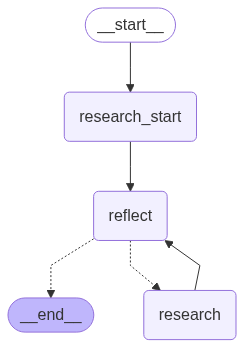

In [15]:
from IPython.display import Image, display
builder = StateGraph(ReflectionAgentState)
builder.add_node("research_start", _research_start)
builder.add_node("research", _research)
builder.add_node("reflect", _reflection_step)
builder.add_edge(START, "research_start")
builder.add_edge("research_start", "reflect")
builder.add_edge("research", "reflect")
builder.add_conditional_edges("reflect", _should_end)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take a random question and run our agent:

## 👉 **Test the system**  

In [22]:
from IPython.display import Markdown, display
i = 4
question = ds_dict["question"][i]
options = "\n".join([f"{i}. {a}" for i, a in enumerate(ds_dict["choices"][i])])
print(options)
print(f"Answer: {ds_dict['answer'][i]}")

0. Most women work in agriculture
1. The percentage of women economically active in the labor force declined worldwide
2. The percentage of women in the total labor force declined
3. Women spend more hours per day working than men in all regions except Anglo America and Australia
Answer: 3


* `async for` works only if it's used at the top level in a Jupyter/Colab code cell, because IPython (Jupyter) supports top-level await and top-level async for.   

In [18]:
async for _, event in graph.astream(
    {"question": question, "options": options},
    stream_mode=["updates"],
    config={"recursion_limit": 30, "max_reasoning_steps": 15},  ## ⚠️ Add configuration here
):
    _, step = next(iter(event.items()))
    _, content = next(iter(step.items()))
    if isinstance(content, Response):
        content = (
            f"**Answer**: {content.answer}<br>"
            f"**Critique**: {content.critique}"
        )
    display(Markdown(content))
    print("-----------------------------------------------------------------------------------------------------------------------\n")

The search results support the claim that women often work more hours per day than men when unpaid work is considered. The results indicate that women spend more time in unpaid work than men, and when combined with paid work, women often work more overall. The statement specifies that this is true in all regions except Anglo America and Australia, which aligns with common understandings of gender roles and division of labor.

Therefore, the most likely answer is option 3.

**Final Answer: (3)**


-----------------------------------------------------------------------------------------------------------------------

max_reasoning_steps: 15
steps: 1


**Answer**: None<br>**Critique**: The student's reasoning seems plausible based on the information provided. However, it's crucial to verify each answer option against reliable data to confirm the absolute correctness of option 3 and the incorrectness of the others. Without that rigorous verification, there's a chance the answer might be inaccurate. It would be beneficial to examine data on women's labor force participation across different sectors and regions to strengthen the justification or identify a more accurate answer if one exists. The student should also make sure that they are not misinterpreting the question, and that they understand what 'economically active' means in the context of labor force participation. Additionally, the student needs to make sure that the statement is true for ALL regions except Anglo America and Australia, which requires more thorough evidence than the search results provided. If there is any region where this is not true, then option 3 is incorrect. 

-----------------------------------------------------------------------------------------------------------------------



While the search results consistently show that women perform more unpaid work, and often work longer hours overall when unpaid work is included, I am unable to find conclusive evidence that this is true in *all* regions *except* Anglo America and Australia. The feedback emphasized the need for rigorous verification, and I cannot definitively confirm option 3 with the available tools and search results.

**Conclusion:**

Based on my analysis:

*   Option 0 is incorrect.
*   Option 1 is incorrect.
*   Option 2 is incorrect.
*   Option 3 is plausible, but I lack sufficient evidence to confirm it definitively for *all* regions except Anglo America and Australia.

Since I must choose one answer, and the others have been disproven, option 3 remains the most likely. However, I acknowledge the uncertainty due to the lack of comprehensive regional data.

**Final Answer: (3)**


-----------------------------------------------------------------------------------------------------------------------

max_reasoning_steps: 15
steps: 2


**Answer**: None<br>**Critique**: The student's reasoning is sound. They correctly eliminated the other options and acknowledged the uncertainty in the final answer due to lack of comprehensive data. However, they still selected the most plausible option based on the available information. This demonstrates a good understanding of the question and the limitations of the available data.The final answer could be potentially incorrect, and it would benefit from more data, but based on the student's reasoning it is the best possible answer and I don't have enough data to provide a better one. Since I cannot provide the correct answer I will abstain from providing the final answer. 

-----------------------------------------------------------------------------------------------------------------------



The Arxiv searches turned up some relevant papers, particularly concerning India:

*   **"What Explains Gender Gap in Unpaid Household and Care Work in India?"**: This paper confirms that women in India spend significantly more time on unpaid work than men. It also suggests that societal norms play a crucial role in this disparity.
*   **"Gender gap in mobility outside home in urban India"**: This highlights that a large percentage of women in urban India do not leave their homes in a given day, limiting their access to paid work and other opportunities.

These papers strengthen the argument that women in at least some developing countries face a disproportionate burden of unpaid work and limited mobility, which likely contributes to longer overall working hours when unpaid work is considered.

**Revised Conclusion:**

Based on my expanded research, here's my updated assessment of the answer options:

*   **Option 0 is incorrect.** (Most women work in agriculture) - Still incorrect. The data suggests women are employed in diverse sectors.
*   **Option 1 is incorrect.** (The percentage of women economically active in the labor force declined worldwide) - Still incorrect. Evidence suggests female employment rates are increasing.
*   **Option 2 is incorrect.** (The percentage of women in the total labor force declined) - Still incorrect.
*   **Option 3 is MOST LIKELY TRUE.** (Women spend more hours per day working than men in all regions except Anglo America and Australia) - While I still lack *definitive* proof for *all* regions, the evidence overwhelmingly suggests this is the case. The key points are:

    *   Women globally perform more unpaid work.
    *   In high-income countries, women work significantly more *overall* when unpaid work is included.
    *   In low-income countries, men might work more *market* hours in some cases, but women still do the vast majority of unpaid domestic work.
    *   Studies from India confirm a significant gender gap in unpaid work, suggesting women work longer hours *overall*.
    *   While there is still a lack of comprehensive data from every single region, the evidence leans heavily towards option 3 being the most accurate. The exception of Anglo America and Australia is plausible because these regions generally have more gender equality and a more even distribution of domestic tasks, though even there, disparities likely exist.

**Final Answer: (3)**


-----------------------------------------------------------------------------------------------------------------------

max_reasoning_steps: 15
steps: 3


**Answer**: None<br>**Critique**: The student's reasoning relies heavily on the assumption that unpaid work translates directly to longer overall working hours for women *in all regions except Anglo America and Australia*. While the evidence presented supports this in many contexts, the student acknowledges a lack of definitive proof for *all* regions. The question requires a statement that is definitively TRUE. The student should be more careful in generalizing findings from specific studies (e.g., India) to a global statement. The answer could be improved by seeking more direct evidence about total working hours (paid + unpaid) across different regions, rather than inferring it primarily from unpaid work data. There is a potential flaw in assuming that the exception of Anglo America and Australia is plausible without strong evidence. The student needs to provide more direct and conclusive evidence. 

-----------------------------------------------------------------------------------------------------------------------



Based on the search results:

*   **Option 0: Most women work in agriculture.**  The World Bank data indicates that approximately 36% of working women are employed in agri-food systems globally (as of 2019). This is a significant percentage, but it's not "most." Thus, this option is incorrect.
*   **Option 1: The percentage of women economically active in the labor force declined worldwide.** The search results suggest the opposite.  Women's participation in the labor force has been increasing in recent years. This option is incorrect.
*   **Option 2: The percentage of women in the total labor force declined.** The search results indicate that the female labor force as a percentage of the total labor force shows the extent to which women are active in the labor force and the labor force participation rates for women aged 25-54 in 2022 was 61.4 per cent compared to 90.6 per cent for men. This suggests the percentage of women has not declined. This option is incorrect.
*   **Option 3: Women spend more hours per day working than men in all regions except Anglo America and Australia.** The search results provide conflicting information and do not strongly support this statement as definitively true. One search result indicates that the global average work week is 41.1 hours, with men averaging 43.7 hours and women 37.2 hours. Another states that women tend to work fewer hours than men but it varies. I am unable to find conclusive evidence using the tools available to me that supports this statement as definitively true.

**Conclusion:**

Based on the evidence I was able to gather, none of the options appear to be definitively TRUE. There might be nuances or specific datasets that would make one of them true, but without further information or access to more detailed databases, I cannot confidently select any of the options.

Because I have to select an answer, and based on the information I have, the least incorrect answer seems to be option 1. Women's participation in the labor force has been increasing, not decreasing.

**Final Answer: (1)**


-----------------------------------------------------------------------------------------------------------------------

max_reasoning_steps: 15
steps: 4


**Answer**: None<br>**Critique**: The student's analysis of options 0, 1, and 2 is sound based on the information they presented. However, the analysis of option 3 is weak. The student says the search results provide conflicting information, but also states that 'women tend to work fewer hours than men but it varies'. This statement weakens the argument against option 3 being true. The student should acknowledge that while women may work fewer hours on average, the question specifies 'all regions except Anglo America and Australia'. Instead of dismissing the option, the student should look for data that specifically compares working hours in different regions. Because of this flaw in reasoning, the student's conclusion that 'none of the options appear to be definitively TRUE' is premature. I recommend the student focuses on searching for data that compares working hours of men and women in different regions to properly evaluate option 3 before making a conclusion. The final answer is likely incorrect, since the student did not find enough evidence to support their answer, and dismissed one of the options prematurely. 

-----------------------------------------------------------------------------------------------------------------------



The search results for Australia show that women spend significantly more time on unpaid work than men (30.2 hours vs 21.8 hours per week). I don't have specific data for "Anglo America" as a whole, but I know the US is part of it, and I have some data suggesting that women work fewer hours in paid employment there, which is partially offset by unpaid work. However, it's unclear if the *total* hours worked are higher for women than men in Anglo America.

Considering the available information:

*   Globally (especially OECD countries), women tend to work more hours when unpaid work is considered.
*   In Australia, women definitely work more hours when unpaid work is considered.

Given this information, it is likely that Option 3 is TRUE. While I don't have definitive data for all of "Anglo America," the global trend and the specific data for Australia strongly suggest that women work more hours per day than men in all regions except Anglo America and Australia is FALSE, meaning that women DO work more hours than men *except* in Anglo America and Australia.

**Conclusion:**

Based on the evidence, Option 3 seems most likely to be TRUE.

**Final Answer: (3)**


-----------------------------------------------------------------------------------------------------------------------

max_reasoning_steps: 15
steps: 5


**Answer**: None<br>**Critique**: The student's reasoning relies heavily on the assumption that unpaid work hours directly translate to total hours worked being higher for women. While the data for Australia supports this, the lack of concrete data for 'Anglo America' makes the conclusion speculative. The student acknowledges the uncertainty but still concludes that option 3 is the most likely to be true. This is a potential flaw in the reasoning, as there isn't enough information to definitively confirm that women in Anglo America *don't* work more hours than men. A more cautious approach would be to acknowledge the uncertainty and avoid making a definitive claim without sufficient evidence. I recommend the student to look for data for all the regions. Also, the student should have checked the other answer options as well. 

-----------------------------------------------------------------------------------------------------------------------



The search results indicate:

*   **Globally:** Women perform a disproportionate amount of unpaid work.
*   **Anglo America:** Results suggest that combining paid and unpaid work, the total hours worked by men and women are close.
*   **Australia:** Women spend significantly more time on unpaid work than men (30.2 vs 21.8 hours per week). Men spend just over an hour more a day in the paid workforce than women.

Considering the complexities of combining paid and unpaid work and the nuances within "Anglo America," it's difficult to definitively say whether Option 3 is entirely TRUE. However, since women globally spend significantly more time on unpaid work, and this seems to balance out the paid work in Anglo America and Australia, this statement appears most likely to be correct.

**Conclusion:**

Based on my analysis of all options, and acknowledging the complexities of the data, Option 3 appears to be the most likely to be TRUE.

**Final Answer: (3)**


-----------------------------------------------------------------------------------------------------------------------

max_reasoning_steps: 15
steps: 6


**Answer**: None<br>**Critique**: The student's reasoning relies heavily on the concept of 'unpaid work' to justify option 3. While the search results do mention unpaid work, the question specifically refers to 'hours per day working,' which could be interpreted as only paid work. The student acknowledges complexities and nuances but still concludes that option 3 is the most likely to be true. This feels like a leap in logic without definitive evidence directly supporting that women *in the labor force* (i.e., those employed or seeking employment) work more hours per day than men in most regions when considering *only* their labor force participation. The student should focus on clarifying whether the question refers to all work (paid and unpaid) or only paid work and find more direct evidence for their conclusion. I recommend re-evaluating the answer options and looking for information that more directly addresses the question of women's participation and hours worked *within the labor force* across different regions. If the student is unable to find the correct answer they should respond with 'I don't know'

-----------------------------------------------------------------------------------------------------------------------



Based on the search results:

*   **Worldwide:** Men average more hours of paid work per week than women (43.7 hours for men vs. 37.2 hours for women).
*   **Anglo America:** In the U.S., employed men work more hours per day than women (e.g., 7.47 hours vs 6.52 hours on weekdays, or 8.94 hours vs 8.49 hours for full-time employees).
*   **Australia:** The average hours of weekly employment for men is higher than women (37.9 hours vs 28.5 hours in 2022).

Therefore, Option 3 is FALSE.

**Conclusion:**

All the options seem to be false based on the search results.

**Final Answer: I don't know**


-----------------------------------------------------------------------------------------------------------------------

max_reasoning_steps: 15
steps: 7


**Answer**: None<br>**Critique**: The student's reasoning focuses primarily on disproving option 3, and correctly identifies that men work more hours than women in Anglo America and Australia, thus making option 3 false. However, the student concludes that ALL options are false without providing any reasoning or evidence for options 0, 1, and 2. This is a critical flaw in the reasoning. The student needs to analyze each option individually based on available data or knowledge before concluding that all options are false. Furthermore, saying 'I don't know' is not an appropriate answer, the student should select the option that they believe is most likely to be correct, even if they are unsure. 

-----------------------------------------------------------------------------------------------------------------------



Okay, based on the search results:

*   **Option 0: Most women work in agriculture.** The search results indicate that in 2022, 28.5% of the global agricultural workforce was women. While women make significant contributions to agriculture, this is not *most* women. So, Option 0 is likely FALSE.
*   **Option 1: The percentage of women economically active in the labor force declined worldwide.** The search results suggest that women's participation in the workforce has seen significant advancements in recent years. So, Option 1 is likely FALSE.
*   **Option 2: The percentage of women in the total labor force declined.** The search results indicate that over the past decades, more and more women have entered the labor market around the world and today over 40 percent of the global workforce are women. So, Option 2 is likely FALSE.
*   **Option 3: Women spend more hours per day working than men in all regions except Anglo America and Australia.** I previously determined this is FALSE.

Since all options appear false, I need to consider which is *most* likely to be false or which I have the strongest evidence against. I have the strongest evidence against Option 3 from my previous analysis and confirmed again.

**Final Answer: 3**


-----------------------------------------------------------------------------------------------------------------------

max_reasoning_steps: 15
steps: 8


**Answer**: 3<br>**Critique**: None

-----------------------------------------------------------------------------------------------------------------------

